In [32]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import re, string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marianne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/marianne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marianne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/marianne/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/marianne/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Loading job dataset
job_df = pd.read_csv('../job-etl/data/csv/job_20221116.csv')
job_df.head()

,id,title,date,level,type,location,description,link,category,company,e_date,t_date,l_date,it_spec
0,3301070910,(Brazil) Junior Business Development Specialis...,2022-10-03,Assistente,Tempo integral,"Brasília, DF","Have a gut for a great deal?Building positive,...",https://br.linkedin.com/jobs/view/brazil-junio...,NaN,SupportYourApp,2022-10-14,2022-11-07,2022-11-07,0
1,3264776485,(Evento SEnEC) - Desenvolvedor SW Junior - Clo...,2022-09-13,Assistente,Tempo integral,Campinas e Região,Job DescriptionSe você tem o espírito criativo...,https://br.linkedin.com/jobs/view/evento-senec...,NaN,SiDi,2022-09-30,2022-11-07,2022-11-07,1
2,3306116559,(G) Técnico De Suporte - Júnior,NaN,Assistente,Tempo integral,"Campo Bom, RS",Vaga de (G) Técnico De Suporte - Júnior em Rio...,https://br.linkedin.com/jobs/view/g-t%C3%A9cni...,NaN,3AM IT Services,2022-10-14,2022-11-07,2022-11-07,1
3,3325496787,[Meios de pagamento] QA Júnior,2022-10-14,Assistente,Tempo integral,"Rio de Janeiro, RJ",#OTime:O time Meios de Pagamento é responsável...,https://br.linkedin.com/jobs/view/meios-de-pag...,NaN,Stone,2022-10-31,2022-11-07,2022-11-07,1
4,3303776344,Academia SAP UTILITIES 2022,2022-10-06,Assistente,Tempo integral,Recife e Região,O que é a Academia SAP?Academia SAP é um progr...,https://br.linkedin.com/jobs/view/academia-sap...,NaN,Accenture Brasil,2022-10-14,2022-11-07,2022-11-07,0


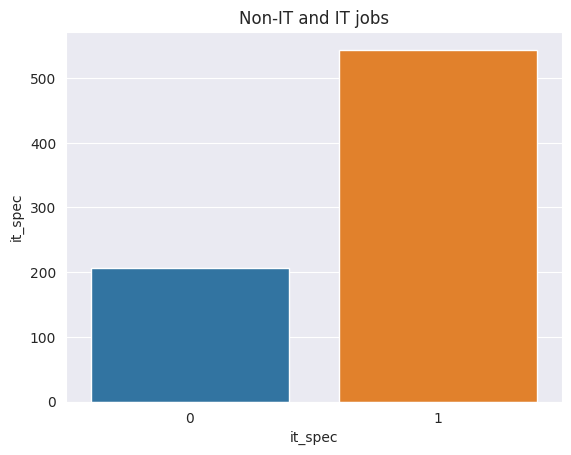

In [3]:
# Job class distribution
sns.set_style('darkgrid')
sns.barplot(data=job_df, x='it_spec', y=job_df['it_spec'].value_counts()).set(title='Non-IT and IT jobs')
plt.show()


In [4]:
# Title word count
job_df['word_count'] = job_df['title'].apply(lambda x: len(str(x).split()))
print("Os títulos de vagas de TI tem em média {} palavras. \n".format(job_df[job_df['it_spec']==1]['word_count'].mean().round(2))) # IT jobs
print("Os títulos de vagas Não-TI tem em média {} palavras. \n".format(job_df[job_df['it_spec']==0]['word_count'].mean().round(2))) # Non-IT jobs

Os títulos de vagas de TI tem em média 4.99 palavras. 

Os títulos de vagas Não-TI tem em média 4.67 palavras. 



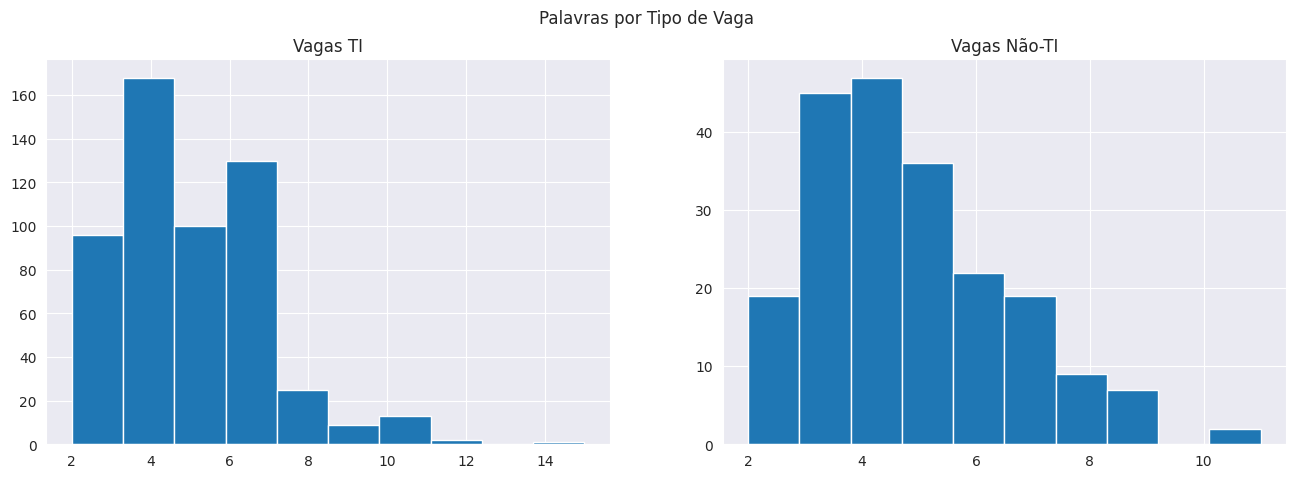

In [5]:
# Word count plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 5))
titles_it = job_df[job_df['it_spec']==1]['word_count']
ax1.hist(titles_it)
ax1.set_title('Vagas TI')
titles_nit = job_df[job_df['it_spec']==0]['word_count']
ax2.hist(titles_nit)
ax2.set_title('Vagas Não-TI')
fig.suptitle('Palavras por Tipo de Vaga')
plt.show()

In [6]:
# Title character count
job_df['char_count'] = job_df['title'].apply(lambda x: len(str(x)))
print("Os títulos de vagas de TI tem em média {} caracteres. \n".format(job_df[job_df['it_spec']==1]['char_count'].mean().round(2))) # IT jobs
print("Os títulos de vagas Não-TI tem em média {} caracteres. \n".format(job_df[job_df['it_spec']==0]['char_count'].mean().round(2))) # Non-IT jobs

Os títulos de vagas de TI tem em média 34.96 caracteres. 

Os títulos de vagas Não-TI tem em média 32.86 caracteres. 



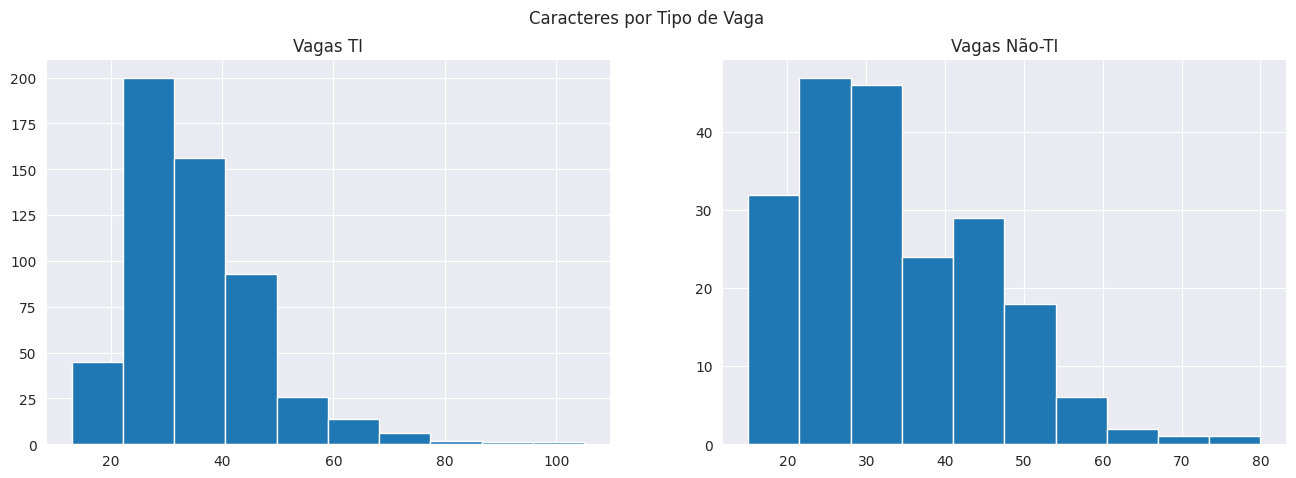

In [7]:
# Character count plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 5))
titles_it = job_df[job_df['it_spec']==1]['char_count']
ax1.hist(titles_it)
ax1.set_title('Vagas TI')
titles_nit = job_df[job_df['it_spec']==0]['char_count']
ax2.hist(titles_nit)
ax2.set_title('Vagas Não-TI')
fig.suptitle('Caracteres por Tipo de Vaga')
plt.show()

In [55]:
# Convert text to lowercase, strip and remove punctuations
def preprocess(text):
    locations = ['brasil', 'sao paulo', 'curitiba', 'campinas']
    position_specs = ['junior', 'jr', 'assistant', 'pleno', 'senior', 'job']
    
    text = text.lower()
    text = text.strip()
    text = re.compile('[%]').sub('', text)
    text = re.compile('(%)').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub('/', ' ', text)
    text = re.sub('ú', 'u', text)
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    
    for i in range(0, len(locations)):
        text = re.sub(locations[i], '', text)
    
    for i in range (0, len(position_specs)):
        text = re.sub(position_specs[i], '', text)
     
    return text

# Stopword removal
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words(['english', 'portuguese', 'spanish'])]
    return ' '.join(a)

# Lemmatization
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [56]:
job_df['clean_title'] = job_df['title'].apply(lambda x: finalpreprocess(x))
job_df.sample(10)

,id,title,date,level,type,location,description,link,category,company,e_date,t_date,l_date,it_spec,word_count,char_count,clean_title
206,3315663213,App Dev Architecture - Sao Paulo,2022-10-24,Assistente,Tempo integral,"Minas Gerais, Brasil",OverviewDo you have a passion for solving the ...,https://br.linkedin.com/jobs/view/app-dev-arch...,NaN,Microsoft,2022-10-31,2022-11-07,2022-11-07,1,6,32,app dev architecture
255,3177080264,Associate - BackUp Simple,2022-09-22,Assistente,Tempo integral,"São Paulo, SP",Why SoftwareONE?SoftwareONE is a leading globa...,https://br.linkedin.com/jobs/view/associate-ba...,NaN,SoftwareONE,2022-09-30,2022-11-07,2022-11-07,0,4,25,associate backup simple
672,3311035740,Técnico de Suporte N1/N2 Junior,NaN,Assistente,Tempo integral,"São Paulo, SP",DESCRIÇÃO RequisitosConhecimentos em Sistemas ...,https://br.linkedin.com/jobs/view/t%C3%A9cnico...,NaN,Code Group,2022-10-14,2022-11-07,2022-11-07,1,5,31,técnico suporte n n
498,3291720479,Pessoa UI/UX Designer Júnior (vaga exclusiva e...,2022-09-28,Assistente,Tempo integral,"Florianópolis, SC",Ajudamos pessoas a crescerem seus negócios e p...,https://br.linkedin.com/jobs/view/pessoa-ui-ux...,NaN,RD Station,2022-09-30,2022-11-07,2022-11-07,1,11,78,pessoa ui ux designer vaga exclusiva afirmativ...
37,3295000526,Analista de Banco de Dados Junior,2022-09-29,Assistente,Tempo integral,Brasil,Realizará atividades pertinentes a função.Bene...,https://br.linkedin.com/jobs/view/analista-de-...,NaN,Linked RH,2022-09-30,2022-11-07,2022-11-07,1,6,33,analista banco dado
323,3295004956,Desenvolvedor full stack júnior,2022-09-29,Assistente,Tempo integral,"São Paulo, SP","Atuar em .Net framework 4.5+, asp net mvc 5, c...",https://br.linkedin.com/jobs/view/desenvolvedo...,NaN,DOMVS iT,2022-09-30,2022-11-07,2022-11-07,1,4,31,desenvolvedor full stack
637,3296339306,Software Quality Assurance Engineer,2022-10-03,Tempo integral,NaN,"Recife, PE",A B2B Tech em Recife-PE seleciona engenheiro d...,https://br.linkedin.com/jobs/view/software-qua...,NaN,B2B TECH,2022-10-14,2022-11-07,2022-11-07,1,4,35,software quality assurance engineer
616,3299306731,Representante De Desenvolvimento De Vendas - SDR,NaN,Assistente,Tempo integral,"Vitória, ES",Vaga de Representante De Desenvolvimento De Ve...,https://br.linkedin.com/jobs/view/representant...,NaN,EZOps,2022-10-03,2022-11-07,2022-11-07,0,7,48,representante desenvolvimento vendas sdr
158,3281760932,Analista de Testes Júnior,2022-09-29,Assistente,Tempo integral,São Paulo e Região,Nós da Neogrid estamos em busca de pessoas que...,https://br.linkedin.com/jobs/view/analista-de-...,NaN,Neogrid,2022-09-30,2022-11-07,2022-11-07,1,4,25,analista testis
586,3284954178,Remote Junior Python Developer Jobs,2022-10-31,Assistente,Tempo integral,Brasil,A global pharmaceutical giant that is actively...,https://br.linkedin.com/jobs/view/remote-junio...,NaN,Turing.com,2022-10-31,2022-11-07,2022-11-07,1,5,35,remote python developer


In [57]:
# Split data into train an test sets
X_train, X_test, y_train, y_test = train_test_split(job_df['clean_title'],job_df['it_spec'],test_size=0.2,shuffle=True)

#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [51]:
len(X_train_tok)

600

In [52]:
len(X_test_tok)

150

In [58]:
X_train_tok

[['estagiário', 'gestão', 'comunidades'],
 ['analista', 'contábil'],
 ['analista', 'suporte', 'bilingue'],
 ['desenvolvedor', 'java'],
 ['trabajos', 'remotos', 'ingeniero', 'datos'],
 ['desenvolvedor', 'frontend'],
 ['analista', 'rpa'],
 ['desenvolvedor', 'java'],
 ['desenvolvedor', 'backend', 'java'],
 ['desenvolvedor', 'java'],
 ['customer', 'support', 'analyst'],
 ['representante', 'desenvolvimento', 'vendas', 'sdr'],
 ['inside', 'sale'],
 ['analista', 'vmware', 'home', 'office'],
 ['analista', 'planejamento'],
 ['trabajos', 'remotos', 'desarrollador', 'full', 'stack'],
 ['app', 'dev', 'architecture'],
 ['remote', 'application', 'developer'],
 ['front', 'end', 'marketing', 'automation', 'vaga', 'afirmativa', 'pcd'],
 ['desenvolvedor', 'front', 'end', 'snior'],
 ['analista', 'programador', 'bm'],
 ['comprador'],
 ['financial', 'analyst'],
 ['trabajos', 'remotos', 'ingeniero', 'software'],
 ['técnico', 'manutenção'],
 ['executivo', 'contas'],
 ['trabajos', 'remotos', 'ingeniero', 'líd

In [59]:
X_test_tok

[['desenvolvedor', 'java'],
 ['remote', 'android', 'engineer'],
 ['pcd', 'técnico', 'suporte'],
 ['remote', 'kafka', 'engineer'],
 ['estágio', 'inteligência', 'negócios'],
 ['engenheiro', 'eletrônico'],
 ['assistente', 'desenvolvimento', 'java'],
 ['remote', 'full', 'stack', 'developer'],
 ['trabajos', 'remotos', 'ingeniero', 'líder', 'full', 'stack'],
 ['analyst'],
 ['executivo', 'contas'],
 ['full', 'stack', 'engineer'],
 ['assistente', 'contábil'],
 ['analista', 'suporte'],
 ['projetista', 'elétrico'],
 ['analista', 'automação', 'testes', 'java'],
 ['software', 'engineer', 'trilogy', 'remote', 'year', 'usd'],
 ['assistente', 'fiscal'],
 ['software', 'quality', 'assurance', 'engineer'],
 ['desenvolvedor', 'full', 'stack'],
 ['trabajos', 'remotos', 'desarrollador', 'front', 'end'],
 ['analista', 'contas', 'pagar', 'espanhol', 'avançado'],
 ['trabajos', 'remotos', 'desarrollador', 'front', 'end'],
 ['accountant'],
 ['dev', 'frontend', 'vuejs', 'angular'],
 ['desenvolvedor', 'net', 'c']

https://vimeo.com/285803636

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

https://stackabuse.com/text-classification-with-python-and-scikit-learn/

https://realpython.com/python-keras-text-classification/

https://www.youtube.com/watch?v=EfEW3_RLnGA&list=PLuXWtea_jmDCcuQZvVJ8X4RVboHXWIltx&index=2&t=719s